# Statistical analysis - experiment 2

### Import the libraries 

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
from csv import reader
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all csv-files in the folder

In [2]:
def list_csv_files(resultsdir):
    csv_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.csv'):
                    if all('' == s for s in subdir):
                        csv_files.append(name)
                    else:
                        csv_files.append(os.path.join(subdirname, name))
    
        csv_files.sort()

    return csv_files

### Function to get all unique combinations

In [3]:
def get_unique_combinations(csv_files):
    unique_combinations = []
    for c in range(len(csv_files)):
        csv_file = csv_files[c]
        splits = csv_file.split("/")
        run_no = splits[0].split("run")[-1]
        sam_mt = splits[1].split("_")[0]
        unc_mt = splits[1].split("_")[1]
        prob = splits[1].split("_")[2]
        fwp = splits[1].split("_")[3]
        sam_sz = splits[1].split("_")[4]
        
        if unc_mt == 'mean':
            unc_mt = 'average'
        
        unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
        unique_combinations.append(unique_combination)
    return list(set(unique_combinations))

### Load the csv-files and store the data in a pandas-dataframe 

In [4]:
resultsdir = "results/exp2"
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
csv_files = list_csv_files(resultsdir)

clmns = ["sampling_method", "certainty_method", "dropout_probability", "number_forward_passes", "sampling_size", "sampling_frequency", "unique_combination", "run", "number_images", "mAP", "mAP_healthy", "mAP_damaged", "mAP_matured", "mAP_cateye", "mAP_headrot"]
df = pd.DataFrame(columns=clmns)
unique_combinations = get_unique_combinations(csv_files)
ucs = [None] * len(unique_combinations)

for c in range(len(csv_files)):
    csv_file = csv_files[c]
    splits = csv_file.split("/")
    run_no = splits[0].split("run")[-1]
    sam_mt = splits[1].split("_")[0]
    unc_mt = splits[1].split("_")[1]
    prob = splits[1].split("_")[2]
    fwp = splits[1].split("_")[3]
    sam_sz = splits[1].split("_")[4]
    sam_freq = 2400 / int(sam_sz)
    
    if unc_mt == 'mean':
        unc_mt = 'average'
        
    unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
    uc_id = unique_combinations.index(unique_combination) 
    ucs[uc_id] = unique_combination

    with open(os.path.join(resultsdir, csv_file), 'r') as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            data = [sam_mt, unc_mt, float(prob), int(fwp), int(sam_sz), int(sam_freq), int(uc_id), int(run_no), int(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6])]
            df.loc[len(df)] = data
            
df

,sampling_method,certainty_method,dropout_probability,number_forward_passes,sampling_size,sampling_frequency,unique_combination,run,number_images,mAP,mAP_healthy,mAP_damaged,mAP_matured,mAP_cateye,mAP_headrot
0,uncertainty,average,0.25,20,100,24,1,1,100,24.9,69.3,0.0,35.7,15.5,3.8
1,uncertainty,average,0.25,20,100,24,1,1,200,29.5,68.3,13.7,46.5,15.0,4.0
2,uncertainty,average,0.25,20,100,24,1,1,300,35.5,69.5,17.1,57.7,22.6,10.7
3,uncertainty,average,0.25,20,100,24,1,1,400,39.2,72.7,27.8,55.1,26.6,13.6
4,uncertainty,average,0.25,20,100,24,1,1,500,41.5,73.4,32.4,56.3,28.6,16.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,uncertainty,average,0.25,20,50,48,0,5,2300,52.9,74.5,55.1,60.3,42.0,32.7
466,uncertainty,average,0.25,20,50,48,0,5,2350,58.7,75.8,63.5,62.6,49.2,42.4
467,uncertainty,average,0.25,20,50,48,0,5,2400,58.7,75.8,63.5,62.6,49.2,42.4
468,uncertainty,average,0.25,20,50,48,0,5,2450,58.7,75.8,63.5,62.6,49.2,42.4


In [5]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/interactions_anova.html#Two-way-ANOVA
# https://www.statology.org/fishers-least-significant-difference/
# https://personal.utdallas.edu/~herve/abdi-LSD2010-pretty.pdf
# https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# https://www.youtube.com/watch?v=ZRX4lFtMboo

numimg = [100, 500, 900, 1300, 1700, 2100, 2500]
df1 = df.loc[df['number_images'].isin(numimg)]
num_img = df1["number_images"].values.ravel()
num_img = pd.unique(num_img)
runs = 5

for ni in range(len(num_img)):
    cur_num_img = num_img[ni]
    sel = df1[df1["number_images"] == cur_num_img]
    print("Number of sampled images: {:d}\n".format(cur_num_img))
    mean = sel.groupby(['sampling_frequency']).mean().drop(columns=['dropout_probability'])
    print(mean.round(1))

    nosum_lm = ols("mAP ~ C(sampling_frequency)", data=sel).fit()
    an = anova_lm(nosum_lm)
    print(an)

    t = stats.t.ppf(1-0.025, an.df.Residual)
    LSD = t * np.sqrt(an.mean_sq.Residual * (1/runs + 1/runs))
    print("Least Significant Difference: {:.2f}".format(LSD))

Number of sampled images: 100

                     mAP  mAP_healthy  mAP_damaged  mAP_matured  mAP_cateye  \
sampling_frequency                                                            
6                   22.4         67.0          7.2         26.2         7.8   
12                  22.4         67.0          7.2         26.2         7.8   
24                  22.4         67.0          7.2         26.2         7.8   
48                  22.4         67.0          7.2         26.2         7.8   

                    mAP_headrot  
sampling_frequency               
6                           3.9  
12                          3.9  
24                          3.9  
48                          3.9  
                         df        sum_sq       mean_sq             F  PR(>F)
C(sampling_frequency)   3.0  1.991874e-29  6.639579e-30  5.993482e-31     1.0
Residual               16.0  1.772480e+02  1.107800e+01           NaN     NaN
Least Significant Difference: 4.46
Number of sampled ima

In [6]:
df1.to_csv('/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Results/exp2/exp2.csv', index=False)

## Certainty values

In [7]:
folder = "/home/pieter/maskAL/results/exp2"
numimg = [100, 500, 900, 1300, 1700, 2100, 2500]
subfolders = []

for path, subdirs, files in os.walk(folder):
    for name in files:
        if os.path.splitext(name)[-1] == ".txt" and "trainfiles_iteration" in os.path.splitext(name)[0]:
            if path not in subfolders:
                subfolders.append(path)

clmns = ["sampling_method", "certainty_method", "dropout_probability", "number_forward_passes", "sampling_size", "sampling_frequency", "run", "number_images", "image_name", "certainty_value"]
df2 = pd.DataFrame(columns=clmns)
txtfiles = []

for p in range(len(subfolders)):
    subfolder = subfolders[p]
    txtfiles = glob.glob(subfolder + "/*.txt")
    txtfiles.sort()
    
    run_no = int(subfolder.split("/")[-2][-1])
    combination = subfolder.split("/")[-1]
    sam_mt = combination.split("_")[0]
    unc_mt = combination.split("_")[1]
    prob = combination.split("_")[2]
    fwp = combination.split("_")[3]
    sam_sz = combination.split("_")[4]
    sam_freq = 2400 / int(sam_sz)
    start_img_num = 100

    for tf in range(len(txtfiles)):
        txtfile = txtfiles[tf]
        it_num = int(os.path.splitext(os.path.basename(txtfile))[0][-3:])
        img_num = start_img_num + (int(sam_sz)*it_num)
        
        df3 = pd.read_csv(txtfile, names=["image_name", "certainty_value"])
        df3['certainty_value'] = pd.to_numeric(df3['certainty_value'], errors='coerce')
        if it_num != 0:
            df3 = df3[df3['certainty_value'].notna()]
        df3.insert(loc=0, column='number_images', value=img_num)
        df3.insert(loc=0, column='run', value=run_no)
        df3.insert(loc=0, column='sampling_size', value=sam_sz)
        df3.insert(loc=0, column='sampling_frequency', value=int(sam_freq))
        df3.insert(loc=0, column='number_forward_passes', value=fwp)
        df3.insert(loc=0, column='dropout_probability', value=prob)
        df3.insert(loc=0, column='certainty_method', value=unc_mt)        
        df3.insert(loc=0, column='sampling_method', value=sam_mt)

        df2 = df2.append(df3, ignore_index=True)
df2

,sampling_method,certainty_method,dropout_probability,number_forward_passes,sampling_size,sampling_frequency,run,number_images,image_name,certainty_value
0,uncertainty,mean,0.25,20,100,24,1,100,field26_surfleet/frame_20151104T124151.785351_...,NaN
1,uncertainty,mean,0.25,20,100,24,1,100,field10_mount_vernon/20190625_094629050_RGB_2.jpg,NaN
2,uncertainty,mean,0.25,20,100,24,1,100,field05_blythe/5fde435d72d3b0083d205789_rgb.jpg,NaN
3,uncertainty,mean,0.25,20,100,24,1,100,field02_santa_maria/20181015_214622440_RGB.jpg,NaN
4,uncertainty,mean,0.25,20,100,24,1,100,field02_santa_maria/20181017_162419471_RGB.jpg,NaN
...,...,...,...,...,...,...,...,...,...,...
49995,uncertainty,mean,0.25,20,200,12,5,2500,field25_sexbierum/20200819_094808207048_plant1...,0.810536
49996,uncertainty,mean,0.25,20,200,12,5,2500,field19_sexbierum/20160930_114410.jpg,0.810582
49997,uncertainty,mean,0.25,20,200,12,5,2500,field09_mount_vernon/20190621_102538019_RGB_3.jpg,0.810597
49998,uncertainty,mean,0.25,20,200,12,5,2500,field09_mount_vernon/20190620_183258443_RGB_3.jpg,0.810614


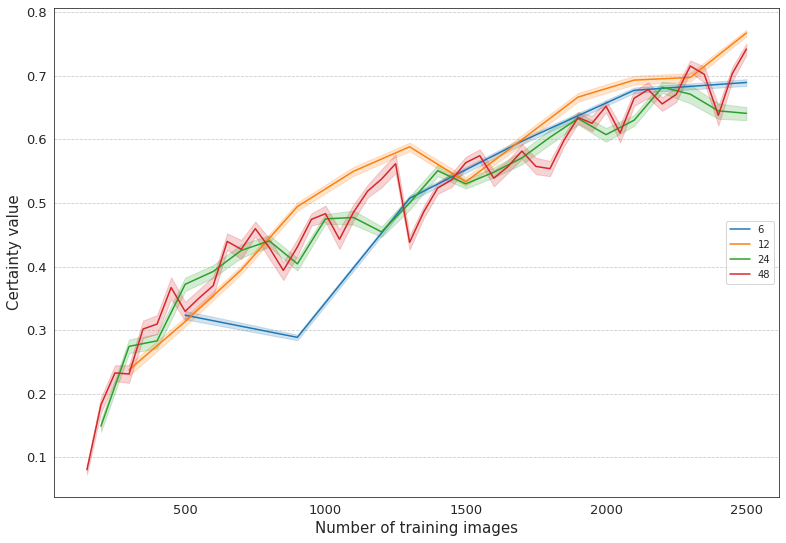

In [8]:
font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("whitegrid")
sns.set_style("white")
f, ax = plt.subplots(figsize=(13, 9))

ax = sns.lineplot(x="number_images", y="certainty_value", hue="sampling_frequency", sizes=[1.5, 2.5], ci=95, data=df2, palette = "tab10")
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(labelrotation=0, labelsize=digit_size)

plt.xlabel('Number of training images', fontsize=font_size)
plt.ylabel('Certainty value', fontsize=font_size)
plt.legend(loc='center right')
plt.show()

### Pooled class instances

In [9]:
supported_cv2_formats = (".bmp", ".dib", ".jpeg", ".jpg", ".jpe", ".jp2", ".png", ".pbm", ".pgm", ".ppm", ".sr", ".ras", ".tiff", ".tif")


def check_direxcist(dir):
    if dir is not None:
        if not os.path.exists(dir):
            os.makedirs(dir)  # make new folder


def find_valid_images_and_annotations(rootdir):
    image_annotation_pairs = []

    for root, dirs, files in tqdm(list(os.walk(rootdir))):
        for name in files:
            if name.endswith((".json")):
                full_path = os.path.join(root, name)
                with open(full_path, 'r') as json_file:
                    try:
                        data = json.load(json_file)

                        ## labelme
                        if 'version' in data:
                            annot_format = 'labelme'
                            if 'shapes' in data:
                                if len(data['shapes']) > 0:
                                    imgname = data['imagePath']
                                    imgpath = os.path.join(root, imgname)

                                    if os.path.exists(imgpath):
                                        image_annotation_pairs.append([os.path.basename(root), imgpath, full_path, annot_format])

                    except:
                        continue

    return image_annotation_pairs


def process_labelme_json(jsonfile, classnames):
    group_ids = []

    with open(jsonfile, 'r') as json_file:
        data = json.load(json_file)
        for p in data['shapes']:
            group_ids.append(p['group_id'])

    only_group_ids = [x for x in group_ids if x is not None]
    unique_group_ids = list(set(only_group_ids))
    no_group_ids = sum(x is None for x in group_ids)
    total_masks = len(unique_group_ids) + no_group_ids

    all_unique_masks = np.zeros(total_masks, dtype = object)

    if len(unique_group_ids) > 0:
        unique_group_ids.sort()

        for k in range(len(unique_group_ids)):
            unique_group_id = unique_group_ids[k]
            all_unique_masks[k] = unique_group_id

        for h in range(no_group_ids):
            all_unique_masks[len(unique_group_ids) + h] = "None" + str(h+1)
    else:
        for h in range(no_group_ids):
            all_unique_masks[h] = "None" + str(h+1)    

    category_ids = []
    masks = []
    crowd_ids = []

    for i in range(total_masks):
        category_ids.append([])
        masks.append([])
        crowd_ids.append([])

    none_counter = 0 

    for p in data['shapes']:
        group_id = p['group_id']

        if group_id is None:
            none_counter = none_counter + 1
            fill_id = int(np.where(np.asarray(all_unique_masks) == (str(group_id) + str(none_counter)))[0][0])
        else:
            fill_id = int(np.where(np.asarray(all_unique_masks) == group_id)[0][0])

        classname = p['label']

        try:
            category_ids[fill_id] = classname
            run_further = True
        except:
            print("Cannot find the class name (please check the annotation files)")
            run_further = False

        if run_further:
            if p['shape_type'] == "circle":
                # https://github.com/wkentaro/labelme/issues/537
                bearing_angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 
                180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360]
                            
                orig_x1 = p['points'][0][0]
                orig_y1 = p['points'][0][1]

                orig_x2 = p['points'][1][0]
                orig_y2 = p['points'][1][1]

                cx = (orig_x2 - orig_x1)**2
                cy = (orig_y2 - orig_y1)**2
                radius = math.sqrt(cx + cy)

                circle_polygon = []
            
                for k in range(0, len(bearing_angles) - 1):
                    ad1 = math.radians(bearing_angles[k])
                    x1 = radius * math.cos(ad1)
                    y1 = radius * math.sin(ad1)
                    circle_polygon.append( (orig_x1 + x1, orig_y1 + y1) )

                    ad2 = math.radians(bearing_angles[k+1])
                    x2 = radius * math.cos(ad2)  
                    y2 = radius * math.sin(ad2)
                    circle_polygon.append( (orig_x1 + x2, orig_y1 + y2) )

                pts = np.asarray(circle_polygon).astype(np.float32)
                pts = pts.reshape((-1,1,2))
                points = np.asarray(pts).flatten().tolist()
                
            if p['shape_type'] == "rectangle":
                (x1, y1), (x2, y2) = p['points']
                x1, x2 = sorted([x1, x2])
                y1, y2 = sorted([y1, y2])
                points = [x1, y1, x2, y1, x2, y2, x1, y2]

            if p['shape_type'] == "polygon":
                points = p['points']
                pts = np.asarray(points).astype(np.float32).reshape(-1,1,2)   
                points = np.asarray(pts).flatten().tolist()

            masks[fill_id].append(points)

            ## labelme version 4.5.6 does not have a crowd_id, so fill it with zeros
            crowd_ids[fill_id] = 0
            status = "successful"
        else:
            status = "unsuccessful"

    return category_ids, masks, crowd_ids, status

Sampling frequency: 6


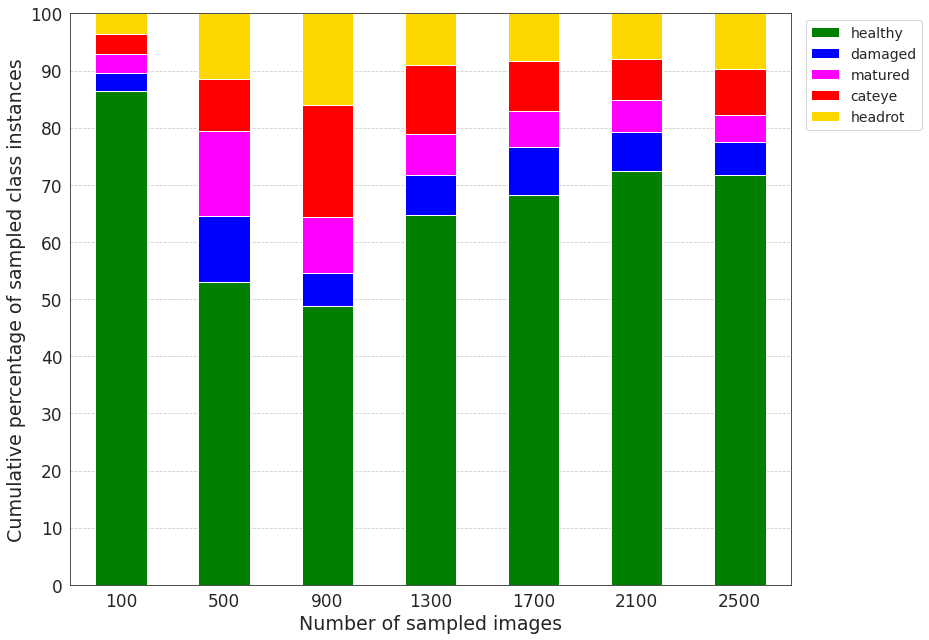

Sampling frequency: 12


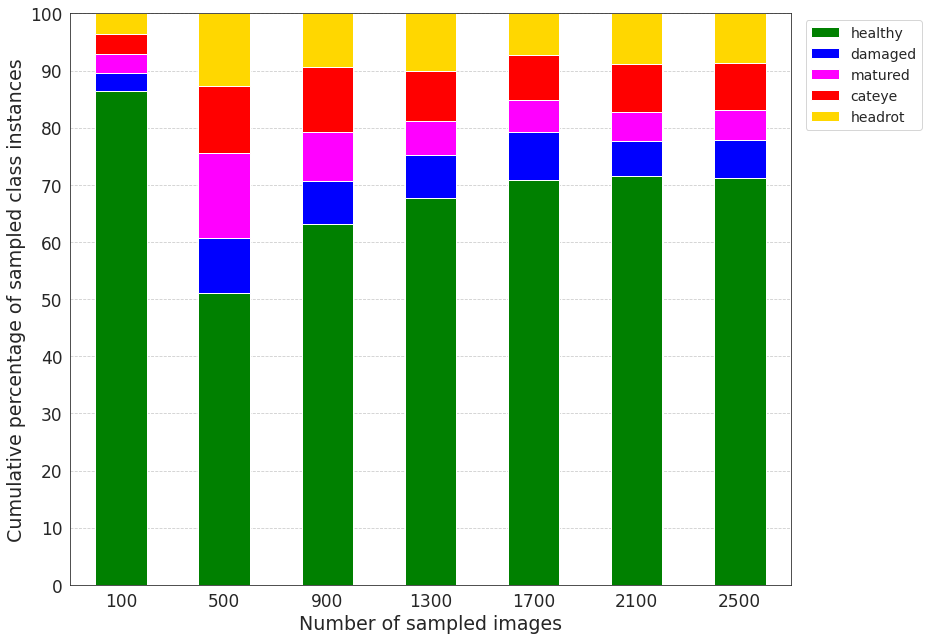

Sampling frequency: 24


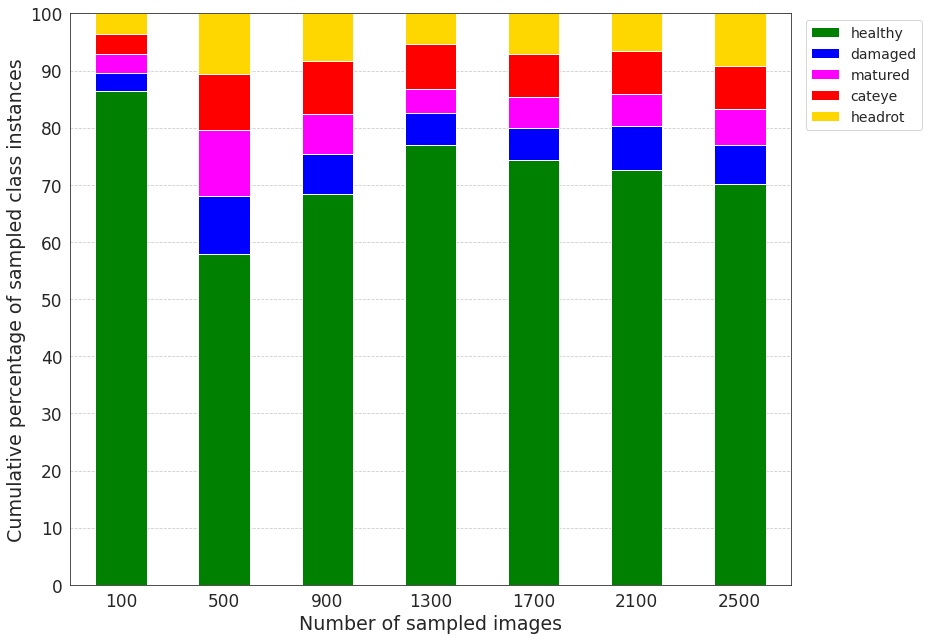

Sampling frequency: 48


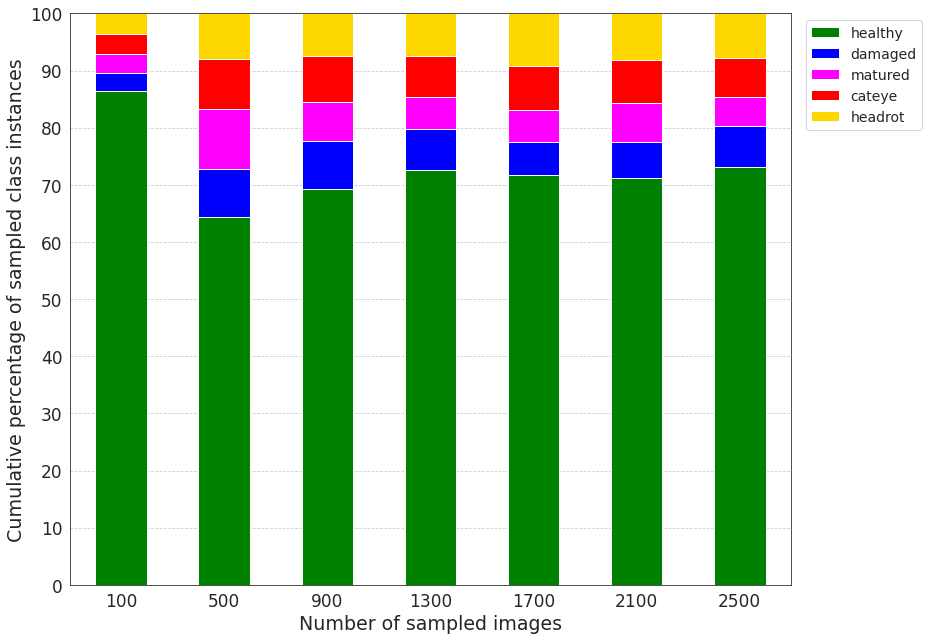

In [10]:
imgdir = "/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Data/train"
writedir = "/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Results/exp2"
font_size = 19
digit_size = 17
annot_size = 14

classes = ['healthy', 'damaged', 'matured', 'cateye', 'headrot']
class_names = ['healthy_total', 'damaged_total', 'matured_total', 'cateye_total', 'headrot_total']
header = class_names.copy()
header.insert(0, 'iteration')
header.insert(1, 'train size')
iters = [0, 1, 2, 3, 4, 5, 6]
numimg = [100, 500, 900, 1300, 1700, 2100, 2500]
color={"healthy": "green", "damaged": "blue", "matured": "magenta", "cateye": "red", "headrot": "gold"}

samp_freq = df2["sampling_frequency"].values.ravel()
samp_freq = pd.unique(samp_freq)
samp_freq.sort()

for sf in range(len(samp_freq)):
    data_combined = []
    cur_samp_freq = samp_freq[sf]
    sel = df2[df2["sampling_frequency"] == cur_samp_freq]
    print("Sampling frequency: {:d}".format(cur_samp_freq))

    for ni in range(len(numimg)):
        class_categories = []
        iter = iters[ni]
        if ni == 0:
            sel_ni = sel[sel["number_images"] == numimg[ni]]
            cur_num_img = numimg[ni]
        else:
            prev_num_img = numimg[ni-1]
            cur_num_img = numimg[ni]
            sel_ni = sel[sel['number_images'].between(prev_num_img+1, cur_num_img)]
            
        image_names = sel_ni['image_name'].tolist()

        for im in range(len(image_names)):
            img_name = image_names[im]
            basename = os.path.splitext(img_name)[0]
            annot_name = basename + ".json"
            annot_file = os.path.join(imgdir, annot_name)

            if os.path.exists(annot_file):
                categories, masks, crowd_ids, status = process_labelme_json(annot_file, classes)

                for c in range(len(categories)):
                    category = categories[c]
                    class_categories.append(category)
                    
        ucc = list(Counter(class_categories).keys())
        vcc = list(Counter(class_categories).values())
        count_list = np.zeros(len(classes)).astype(np.int16)

        for b in range(len(classes)):
            _class = classes[b]
            idx = ucc.index(_class)
            count_list[b] = vcc[idx]
            
        data_to_merge = list(count_list)
        data_to_merge.insert(0, iter)
        data_to_merge.insert(1, cur_num_img)
        data_combined.append(data_to_merge)

    df4 = pd.DataFrame(data=data_combined, columns=header)
    df4.sort_values(by=['iteration'], ignore_index=True, inplace=True)
    pool_size = df4['train size'][1] - df4['train size'][0]

    cum_values = []
    total = df4.copy()
    total['sum'] = df4.loc[:, class_names[0]:class_names[-1]].sum(axis=1)
    total.drop(columns=class_names)

    for c in range(len(classes)):
        _class = classes[c]
        class_name = class_names[c]
        total[_class] = (df4.loc[:][class_name] / total['sum']) * 100

    df5 = total.loc[:, classes[0]:classes[-1]]
    ax = df5.plot.bar(stacked=True, figsize=(13, 9), color=color)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_ylim([0, 100])

    plt.subplots_adjust(right=0.85)
    plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize=annot_size)
    plt.xlabel('Number of sampled images', fontsize=font_size)
    plt.xticks(range(0, df4['iteration'].max()+1), range(df4['train size'][0], df4['train size'].max()+pool_size, pool_size), fontsize=digit_size, rotation='horizontal')
    plt.ylabel('Cumulative percentage of sampled class instances', fontsize=font_size)
    plt.yticks(np.arange(0, 110, 10), fontsize=digit_size)

    plt.tight_layout()
    write_name = "class_instances_sampling_freq_{:d}.png".format(cur_samp_freq)
    plt.savefig(os.path.join(writedir, write_name))
    plt.show()